In [1]:


#rcParams['savefig.dpi'] = 75

#from mpl_toolkits.basemap import Basemap
%matplotlib inline
from matplotlib.pylab import *
import numpy as np

from sigvisa import Sigvisa
from sigvisa.source.event import get_event
from sigvisa.signals.io import fetch_waveform, EventNotDetected, MissingWaveform
from sigvisa.models.ttime import tt_predict
from sigvisa.graph.sigvisa_graph import SigvisaGraph

import cPickle as pickle

from sigvisa.infer.correlations.historical_signal_library import get_historical_signals
from sigvisa.infer.correlations.weighted_event_posterior import compute_atime_posteriors, align_sum, wn_origin_posterior


In [2]:
# load SG with birthed large event
with open("/home/dmoore/python/sigvisa/logs/mcmc/01468/step_000034/pickle.sg", "rb") as f:
    sg = pickle.load(f)

stas = ["ELK",]
proposals = get_historical_signals(sg, stas=stas)
    
# compute unexplained_signal at ELK or wherever
# compute otime posterior for unexplained signal of ev 205
# compute otime posterior for raw signal
# then play with hacks to get the latter to look like the former

reading station detections... 


/home/dmoore/python/sigvisa/models/signal_model.py:662: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return TransientCombinedSSM(components, TSSM_NOISE_PADDING)


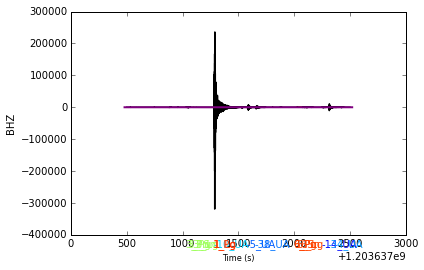

In [3]:
wn = sg.station_waves["ELK"][0]
wn._parent_values()
wn.plot(ax=plt.gca())

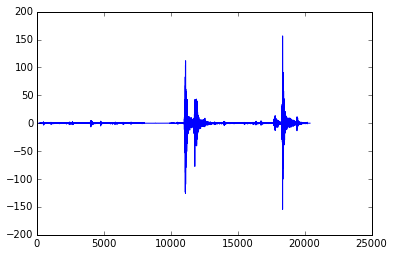

In [4]:
scaled_unexplained = wn.unexplained_kalman() / wn.nm_env.c
plt.plot(scaled_unexplained)



/home/dmoore/.virtualenvs/sigvisa/local/lib/python2.7/site-packages/numpy/ma/core.py:790: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


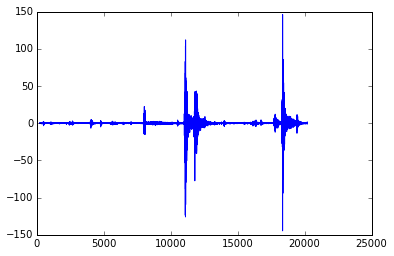

In [5]:
ev_arrivals = [(eid, phase) for (eid, phase) in wn.arrivals() if phase!="UA"]
env = wn.assem_env(arrivals=ev_arrivals) + wn.nm_env.c

#plt.plot(env)

plt.plot(wn.get_value() /env)

In [6]:
from sigvisa.infer.correlations.ar_correlation_model import iid_advantage

ll = [(i, proposals[i][0]) for i in range(len(proposals)) if -114.9247 < proposals[i][0][0,0] < -114.9245]
for l in ll:
    print l
    
    
#iid_advantage()

(140, array([[-114.9246,   41.1125,   10.    ,   48.6667,    4.5   ]]))


In [7]:
pg, lg = proposals[140][1].values()

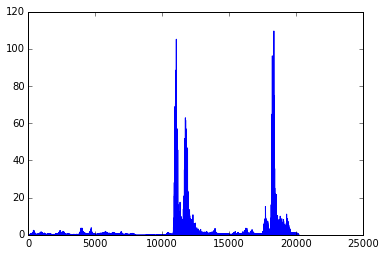

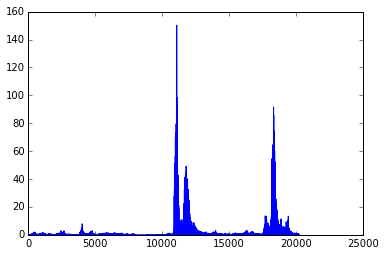

In [8]:
pg_unexplained = np.sqrt(iid_advantage(scaled_unexplained, pg))
lg_unexplained = np.sqrt(iid_advantage(scaled_unexplained, lg))

plt.plot(pg_unexplained)
plt.figure()
plt.plot(lg_unexplained)

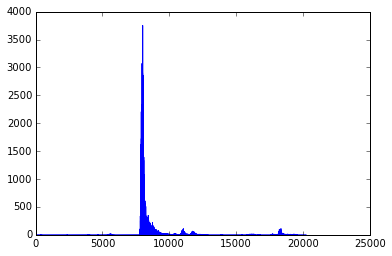

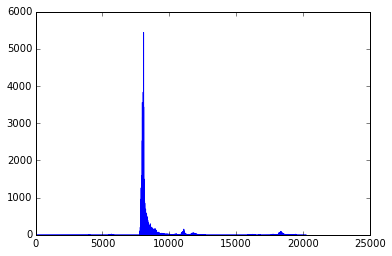

In [9]:
d = wn.get_value().copy()
d[np.isnan(d)] = 0.0
d = d / wn.nm_env.c

pg_base = np.sqrt(iid_advantage(d, pg))
lg_base = np.sqrt(iid_advantage(d, lg))

plt.plot(pg_base)
plt.figure()
plt.plot(lg_base)

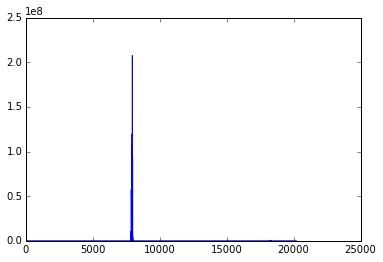

In [10]:
plt.plot(pg_base / (env[:len(pg_base)]**2/100000.0))

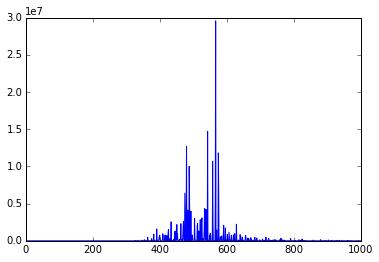

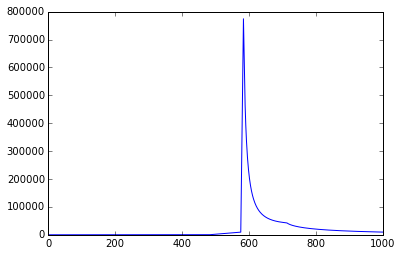

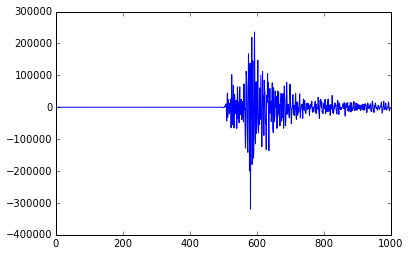

In [22]:
plt.plot(lg_base[7500:8500])
plt.figure()
plt.plot(env[7500:8500])
plt.figure()
plt.plot(wn.get_value()[7500:8500])

In [10]:
from sigvisa.utils.array import index_to_time, time_to_index
lg_base_zeroed = lg_base.copy()

global_srate=wn.srate
timeshift=0
origin_stime=wn.st
pre_s=20.0

for (eid, phase) in wn.arrivals():
    if phase=="UA": continue
    v, tg = wn.get_template_params_for_arrival(eid, phase)
    atime = v["arrival_time"]
    otime = atime - timeshift
    ot_idx = time_to_index(otime, origin_stime, global_srate)

    tmpl_len_wnidx = int(20.0 * wn.srate)
    #tmpl_len_wnidx = max(tmpl_len_wnidx,  tg.abstract_logenv_length(v, min_logenv=np.log(wn.nm_env.c), srate=wn.srate))
    tmpl_len_gidx = int(tmpl_len_wnidx * (global_srate / wn.srate))

    sidx = ot_idx - int(pre_s * global_srate)
    eidx = ot_idx + tmpl_len_gidx
    sidx = max(sidx, 0)
    eidx = min(eidx, len(lg_base_zeroed))
    if sidx > len(lg_base_zeroed) or eidx < 0:
        continue
    lg_base_zeroed[sidx:eidx] = 0.0

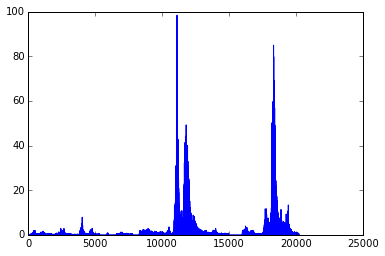

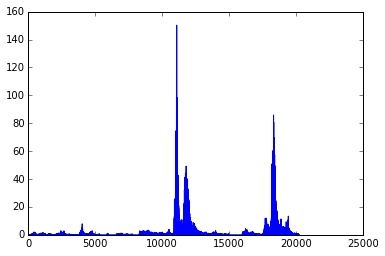

In [11]:
env_scaled = env / (wn.nm_env.c)

plt.plot(lg_base_zeroed / env_scaled[:-200])
plt.figure()
plt.plot(lg_base_zeroed / env_scaled[100:-100])

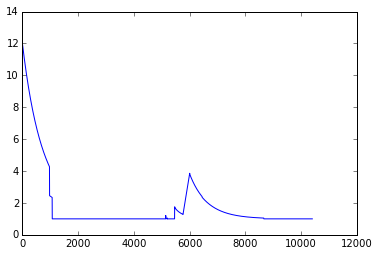

In [49]:
plt.plot(env_scaled[10000:])

In [14]:
x = proposals[140][0]
from sigvisa.infer.correlations.weighted_event_posterior import build_ttr_model_array, atime_likelihood_to_origin_likelihood
ttr_model, mean_tt = build_ttr_model_array(sg, x, "ELK", 1.0, K=None, phase="Lg")
otime_ll, origin_stime = atime_likelihood_to_origin_likelihood(lg_base, wn.st, wn.srate, mean_tt, ttr_model, 1.0)

/home/dmoore/python/sigvisa/infer/correlations/weighted_event_posterior.py:107: RuntimeWarning: divide by zero encountered in log
  origin_ll = np.log(rr) + llmax


/home/dmoore/.virtualenvs/sigvisa/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: RuntimeWarning: overflow encountered in exp
/home/dmoore/.virtualenvs/sigvisa/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log


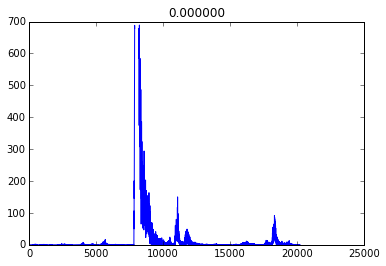

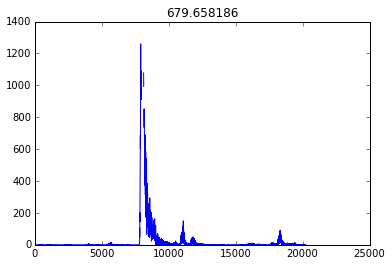

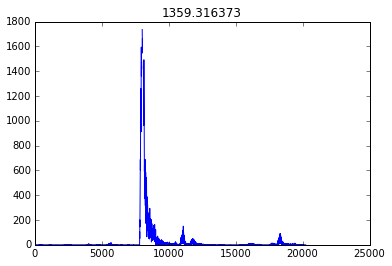

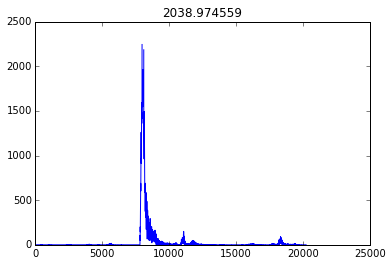

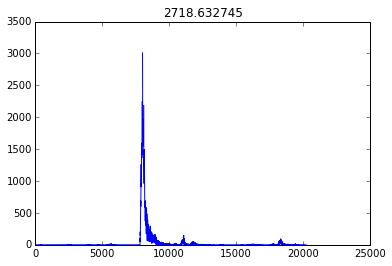

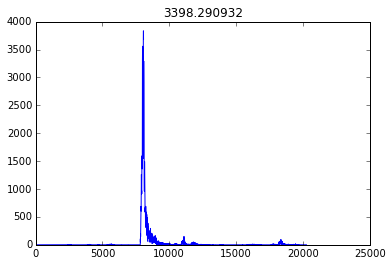

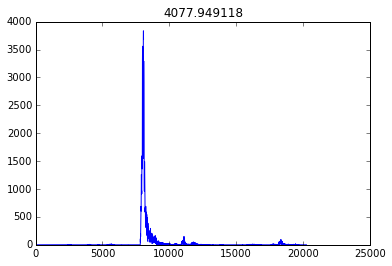

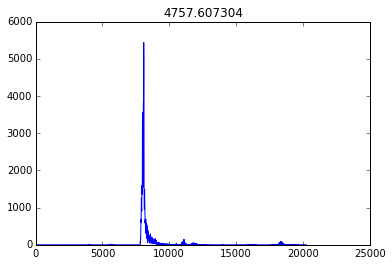

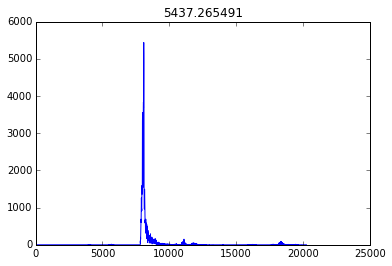

In [50]:
#def hierarchically_stable_convolve(ll, ttr_model):
    
llmax = np.max(ll)
levels = np.linspace(0, llmax, llmax/600)

#levels = [0, 5400]

logrs = []
logr_prev = None
for level in levels:
    ll_exp = np.exp(ll-level)
    r = np.convolve(ll_exp, ttr_model, "full")
    logr = np.log(r) + level
    if logr_prev is None:
        logr = np.where(logr < 0, 0.0, logr )
    else:
        logr = np.where(logr < 0, logr_prev, logr )
    logr_prev = logr
    plt.figure()
    plt.plot(logr)
    plt.title("%f" % level)


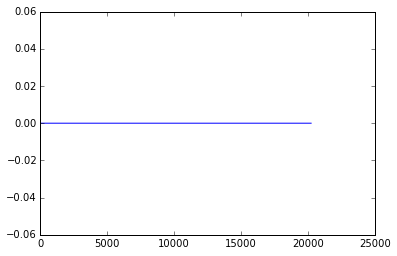

In [53]:
logr_inf = logr
plt.plot(logr-logr_inf)


/home/dmoore/.virtualenvs/sigvisa/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log
/home/dmoore/.virtualenvs/sigvisa/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: RuntimeWarning: overflow encountered in exp


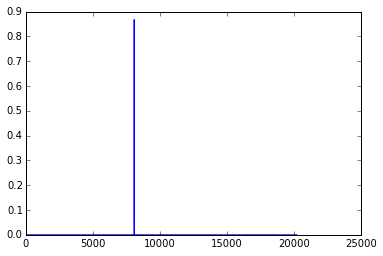

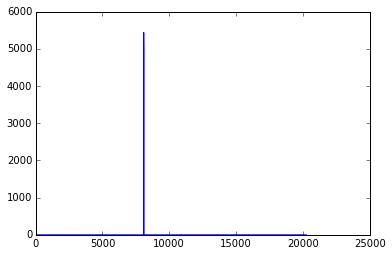

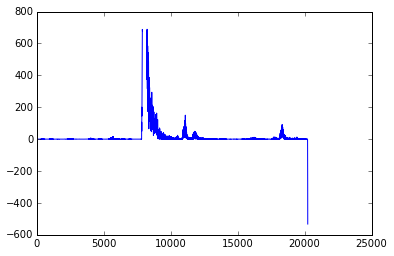

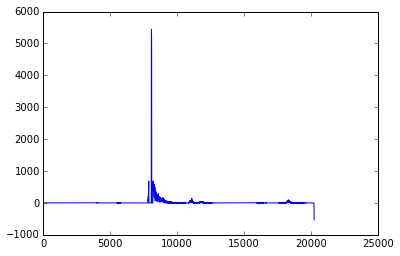

In [25]:
ll = lg_base
llmax = np.max(ll)
ll_exp = np.exp(ll-llmax)
r = np.convolve(ll_exp, ttr_model, "full")
logr = np.log(r) + llmax
logr = np.where(logr < 0, 0.0, logr )


ll_exp2 = np.exp(ll)
r2 = np.convolve(ll_exp2, ttr_model, "full")
logr2 = np.log(r2) 
logr_full = np.where(np.isinf(logr2), logr, logr2 )

plt.plot(r)
plt.figure()
plt.plot(logr)
plt.figure()
plt.plot(logr2)
plt.figure()
plt.plot(logr_full)

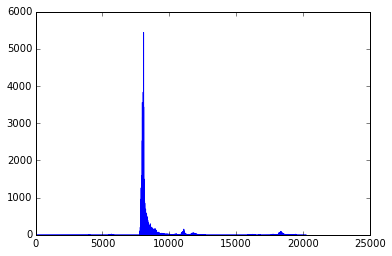

In [16]:
plt.plot(lg_base)

In [75]:
ll = np.loadtxt("/home/dmoore/python/sigvisa/llstuff.txt")
ttr_model = np.loadtxt("/home/dmoore/python/sigvisa/ttr.txt")

srate=10
out_srate=1

ttr_model = np.where(ttr_model==0, 1e-300, ttr_model)

In [81]:
from sigvisa.infer.correlations.weighted_event_posterior import integrate_downsample

llmax = np.max(ll)
nlevels = int(np.ceil(llmax/500.))+1
origin_ll_prev = None

rrs = []
olls_raw = []
olls = []

for level in np.linspace(0, llmax, nlevels):
    ll_exp = np.exp(ll-level)
    r = np.convolve(ll_exp, ttr_model, "full")
    rr = integrate_downsample(r, srate, out_srate)
    origin_ll = np.log(rr) + level

    olls_raw.append(origin_ll)

    if origin_ll_prev is None:
        origin_ll = np.where(origin_ll < 0, 0.0, origin_ll )
    else:
        origin_ll = np.where(origin_ll < 0, origin_ll_prev, origin_ll )

    olls.append(origin_ll)
    rrs.append(rr)

    origin_ll_prev = origin_ll

/home/dmoore/.virtualenvs/sigvisa/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: RuntimeWarning: overflow encountered in exp
/home/dmoore/.virtualenvs/sigvisa/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log


In [83]:
np.sum(np.isnan(origin_ll))

0